<a href="https://colab.research.google.com/github/kd-kdev/CognitiveRadio-LSTM/blob/main/CognitiveRadio_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Cognitive Radio - Channel occupancy prediction using LSTM
Short description of project...
Generate documentation of functions ?
Separate list of requirements like packages & imports ? for future recreation ?

>[PyTorch Cognitive Radio - Channel occupancy prediction using LSTM](#scrollTo=szOWLo_3FYsy)

>>[1. Import libraries & setup](#scrollTo=R-uOLgZWcB4I)

>>[2. Hyperparameters](#scrollTo=8-eDK_jJLcMN)

>>[3. Plotting functions](#scrollTo=T-6tgFbULffj)

>>[4. Simulate channel data](#scrollTo=gVkPvKYpLuhe)

>>[5. Sequence creation & DataLoader](#scrollTo=7-D_fGKNL6Jz)

>>[6. LSTM model definition](#scrollTo=NXTUz7rOMFLL)

>>[7. Training loop](#scrollTo=RHSHqKGMMUZw)

>>[8. Evaluate model on new dataset](#scrollTo=0AvRdlELMbBy)

>>[TESTING](#scrollTo=E4AbDAiDDDXI)



## 1.&nbsp;Import libraries & setup
Imports all related libraries & installs packages (includes optional visualization libs), may require re-run after runtime restart.

In [1]:
import importlib
def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    try:
        importlib.import_module(pkg)
        print(f"{pkg} already installed.")
    except ImportError:
        print(f"Installing {pip_name}...")
        !pip install -q {pip_name}

ensure("torchview")
ensure("torchviz")
ensure("torch_summary", "torch-summary")
ensure("seaborn")

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from torchview import draw_graph
from torchsummary import summary


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Installing torchview...
Installing torchviz...
Installing torch-summary...
seaborn already installed.
Using device: cuda


## 2.&nbsp;Hyperparameters
Central config dictionary - change values here

In [2]:
config = {
    'num_channels': 5,
    'signal_length': 1000,
    'input_window': 100,
    'horizon': 10,
    'hidden_size': 256,
    'batch_size': 64,
    'num_epochs': 100,
    'learning_rate': 0.001,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

config

{'num_channels': 5,
 'signal_length': 1000,
 'input_window': 100,
 'horizon': 10,
 'hidden_size': 256,
 'batch_size': 64,
 'num_epochs': 100,
 'learning_rate': 0.001,
 'device': device(type='cuda')}

## 3.&nbsp;Plotting functions
Contains functions that produce a plot, used later in code for data visualization.

In [3]:
def plot_channels(channel_data, num_channels):
    plt.figure(figsize=(14, 4))

    offset = 1.5
    yticks = []
    yticklabels = []

    for i in range(num_channels):
        rev_i = num_channels - 1 - i
        channel_offset = rev_i * offset

        # Plot actual channel signal
        plt.plot(channel_data[i] + channel_offset, label=f"Channel {i+1}")

        # Add horizontal lines at 0 and 1 for this channel
        plt.hlines(y=channel_offset + 0, xmin=0, xmax=channel_data.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)
        plt.hlines(y=channel_offset + 1, xmin=0, xmax=channel_data.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

        # Set middle point for tick
        mid = channel_offset + 0.5
        yticks.append(mid)
        yticklabels.append(f"Ch {i+1}")

    plt.title("Simulated Channel Occupancy")
    plt.xlabel("Time step")
    plt.ylabel("Occupancy")
    plt.yticks(yticks, yticklabels)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.grid(True)
    plt.show()

def plot_loss(loss_values, num_epochs):
    min_loss_value = min(loss_values)
    min_loss_epoch = loss_values.index(min_loss_value) + 1  # +1 because num_epochs start at 1
    max_loss_value = max(loss_values)
    last_loss_value = loss_values[num_epochs-1]
    # Loss curve plot with best loss highlighted
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', label='Training Loss')

    # Highlight the best loss
    plt.plot(min_loss_epoch, min_loss_value, 'ro', label='Best Loss')
    plt.annotate(f'Best: {min_loss_value:.4f}',
                xy=(min_loss_epoch, min_loss_value),
                xytext=(min_loss_epoch + 1, min_loss_value + 0.01),
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_compact_comparison(X_raw, preds_binary):
    preds_np = preds_binary.cpu().numpy()  # convert to numpy
    num_samples, horizon, num_channels = preds_np.shape

    # Initialize array for full length predictions
    pred_full = np.zeros((num_channels, X_raw.shape[1]))

    # slide horizon predictions over time
    for i in range(num_samples):
        start_idx = i
        end_idx = i + horizon
        if end_idx > X_raw.shape[1]:
            end_idx = X_raw.shape[1]
        signal_length = end_idx - start_idx
        pred_full[:, start_idx:end_idx] = preds_np[i, :signal_length, :].T


    num_channels = X_raw.shape[0]

    fig, axes = plt.subplots(num_channels, 1, figsize=(17, 2*num_channels), sharex=False)

    for i in range(num_channels):
        ax = axes[i]
        ax.plot(X_raw[i], label=f"Actual", linewidth=2)
        ax.plot(pred_full[i], '--', label=f"Predicted", linewidth=2)
        ax.set_ylabel("Occupancy")
        ax.set_ylim(-0.1, 1.1)  # keep 0-1 range
        ax.set_yticks([0, 1])  # only show 0 and 1
        ax.set_title(f"Channel {i+1}")
        ax.grid(True)
        ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)

    axes[-1].set_xlabel("Time step")
    plt.tight_layout()
    plt.show()


def plot_full_comparison(X_raw, pred_full):
    # Stitches together the 891x10x5 predictions into a 1000-step long prediction signal for each channel
    # usable timeline

    # Wider graph with more detail
    num_channels = X_raw.shape[0]
    fig, axes = plt.subplots(num_channels, 1, figsize=(35, 2*num_channels), sharex=False)

    for i in range(num_channels):
        ax = axes[i]

        # Solid line for actual
        ax.plot(X_raw[i], label=f"Channel {i+1} Actual", linewidth=2)

        # Dashed line for predicted
        ax.plot(pred_full[i], '--', label=f"Channel {i+1} Predicted", linewidth=2)

        ax.set_ylabel("Occupancy")
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0, 1])
        ax.set_title(f"Channel {i+1}")

        # Horizontal 0/1 guide lines
        ax.hlines([0, 1], xmin=0, xmax=X_raw.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

        # Vertical guidelines
        ax.set_xticks(np.arange(0, X_raw.shape[1]+1, 50))
        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

        ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)

        # Remove horizontal padding
        ax.margins(x=0.01)

    axes[-1].set_xlabel("Time step")
    plt.tight_layout()
    plt.show()

def heatmap_subgraphed_correctness(X_raw, pred_full):
    # HEATMAP - Subgraphed for every 200 steps

    pred_full_np = pred_full       # shape (5, T)
    X_raw_np = X_raw               # shape (5, T)

    # Ensure binary predictions
    pred_bin = (pred_full_np >= 0.5).astype(int)

    # Correctness matrix: 1 = correct, 0 = incorrect
    correct_matrix = (pred_bin == X_raw_np).astype(int)

    segment_length = 200
    time_steps = correct_matrix.shape[1]
    num_segments = (time_steps + segment_length - 1) // segment_length  # ceil division

    plt.figure(figsize=(30, num_segments * 3))  # height scales per segment

    for seg in range(num_segments):
        start = seg * segment_length
        end = min(start + segment_length, time_steps)

        ax = plt.subplot(num_segments, 1, seg + 1)

        sns.heatmap(
            correct_matrix[:, start:end],
            cmap=["#d9534f", "#5cb85c"],   # red = incorrect, green = correct
            cbar=False,
            linewidths=1,
            linecolor="black",
            square=True
        )

        ax.set_ylabel("Channel", fontsize=14)
        ax.set_yticks(np.arange(correct_matrix.shape[0]) + 0.5)
        ax.set_yticklabels([str(i+1) for i in range(correct_matrix.shape[0])], fontsize=10)

        ax.set_xticks(np.arange(0, end - start, 50))
        ax.set_xticklabels(np.arange(start, end, 50), rotation=90, fontsize=10)

        ax.set_title(f"Time Steps {start} → {end}", fontsize=16, pad=12)

    plt.xlabel("Time Step", fontsize=16)
    plt.tight_layout()
    plt.show()

def heatmap_full_correctness(X_raw, pred_full):
    # HEATMAP - One long scrollable axis

    pred_full_np = pred_full       # shape (5, time_steps)
    X_raw_np = X_raw               # shape (5, time_steps)

    # Ensure binary predictions
    pred_bin = (pred_full_np >= 0.5).astype(int)

    # Correctness matrix: 1 = correct, 0 = incorrect
    correct_matrix = (pred_bin == X_raw_np).astype(int)

    # Make blocks big + scrollable
    plt.figure(figsize=(400, 50))  # <-- increase width here

    ax = sns.heatmap(
        correct_matrix,
        cmap=["#d9534f", "#5cb85c"],   # red wrong, green correct
        cbar=False,
        linewidths=1,
        linecolor="black",
        square=True  # ensures blocks are large squares
    )

    ax.set_xlabel("Time step", fontsize=16)
    ax.set_ylabel("Channel", fontsize=16)

    ax.set_yticks(np.arange(correct_matrix.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(correct_matrix.shape[0])], fontsize=12)

    # Reduce xtick clutter: only show every 50th time step
    ax.set_xticks(np.arange(0, correct_matrix.shape[1], 50))
    ax.set_xticklabels(np.arange(0, correct_matrix.shape[1], 50), rotation=90, fontsize=10)

    plt.title("Prediction Accuracy Heatmap (Large, Scrollable)", fontsize=18, pad=20)
    plt.tight_layout()
    plt.show()


def heatmap_dataset_sample_binary(X, y, sample_index=0, input_window=100, horizon=10):
    marker_position = input_window + horizon  # 110
    # Select the sample
    X_sample = X[sample_index]
    y_sample = y[sample_index]

    # Combine input and horizon along time axis
    combined = np.concatenate([X_sample, y_sample], axis=0).T  # shape -> (5, 110)
    plt.figure(figsize=(13, 8))

    ax = sns.heatmap(
        combined,
        cmap=["#d9534f", "#5cb85c"],
        cbar=False,
        linewidths=0.5,
        linecolor="black",
        square=True
    )
    ax.set_xlabel("Time step", fontsize=16)
    ax.set_ylabel("Channel", fontsize=16)

    # Channels
    ax.set_yticks(np.arange(combined.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(combined.shape[0])], fontsize=6)

    # Vertical line separating input and horizon
    ax.axvline(input_window, color="black", linewidth=4)
    ax.text(input_window + 0.5, -0.5, "←Horizon→", fontsize=10, color="black")

    # Reduce x-tick clutter
    ax.set_xticks(np.arange(0, combined.shape[1], 10))
    ax.set_xticklabels(np.arange(0, combined.shape[1], 10), rotation=90)

    # Ensure 110 is included as a tick and appears below the heatmap
    xticks = list(np.arange(0, combined.shape[1], 10))
    if marker_position not in xticks:
        xticks.append(marker_position)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(t) for t in xticks], rotation=90)

    # Thick vertical line at 110
    ax.axvline(marker_position, color='black', linewidth=3)
    plt.title(f"Dataset Sample #{sample_index}", fontsize=16, pad=20)

    # Define legend entries
    legend_elements = [
        Patch(facecolor='#d9534f', edgecolor='black', label='0'),
        Patch(facecolor='#5cb85c', edgecolor='black', label='1')
    ]
    # Add legend to the axes
    ax.legend(handles=legend_elements, title='Value', loc='upper right', bbox_to_anchor=(1.08, 1.2))
    plt.tight_layout()
    plt.show()

## 4.&nbsp;Simulate channel data
Simulates channels - Return array shape (num_channels, length) with 0/1 occupancy.

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
(5, 1000)


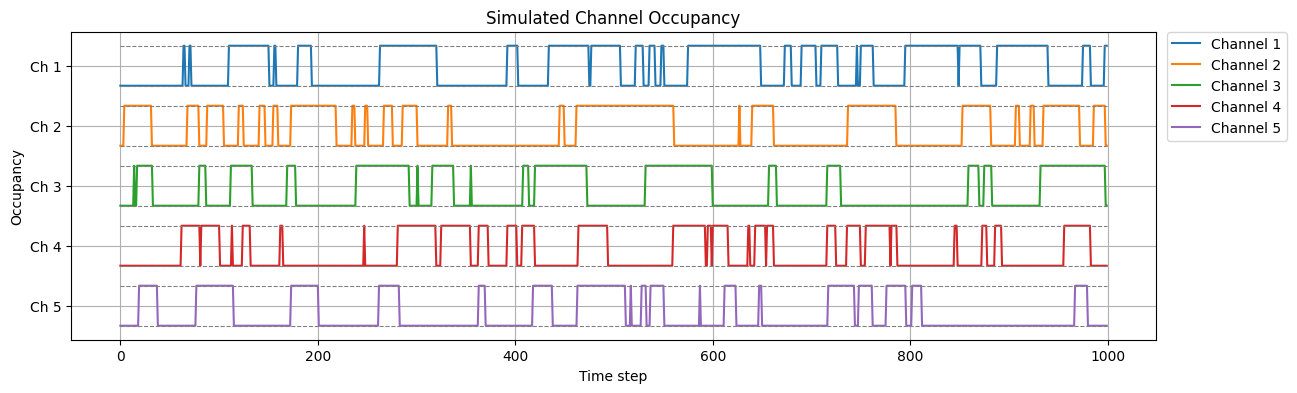

In [4]:
def simulate_multiple_channels(num_channels=config['num_channels'], signal_length=config['signal_length'], avg_on_duration=20, avg_off_duration=30):
    channels = []
    for _ in range(num_channels):
        channel = []
        state = 0
        while len(channel) < signal_length:
            duration = np.random.exponential(scale=avg_on_duration if state == 1 else avg_off_duration)
            duration = int(max(1, round(duration)))
            channel.extend([state] * duration)
            state = 1 - state
        channels.append(channel[:signal_length])

        print(type(channels))
        print(type(channel))
    return np.array(channels)

channel_data = simulate_multiple_channels()
print(type(channel_data))
print(channel_data.shape)
plot_channels(channel_data, config['num_channels'])

## 5.&nbsp;Sequence creation & DataLoader
Converts channel data into X y sliding windows & creates PyTorch DataLoader

In [5]:
channel_data = channel_data.T # this transposes it to shape (time_steps, num_channels) for sequence slicing

def create_sequence(channel_data, input_window=100, horizon=10):
  X = [] # sequence of past channel states, contains a fixed length window of past observations
  y = [] # sequence of steps after 10 steps (horizon, the num. of steps in the future we want to predict)
  for i in range(len(channel_data) - input_window - horizon +1):
    X.append(channel_data[i:i+input_window])
    y.append(channel_data[i+input_window : i+input_window+horizon])
  return np.array(X), np.array(y)

X, y = create_sequence(channel_data, input_window=100, horizon=10)
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# will give you 891 training samples from the dataset, 100 time steps, 5 values per channel

# DataLoader part
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 64 # try out different values like 32 as well
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

X.shape = (891, 100, 5), y.shape = (891, 10, 5)


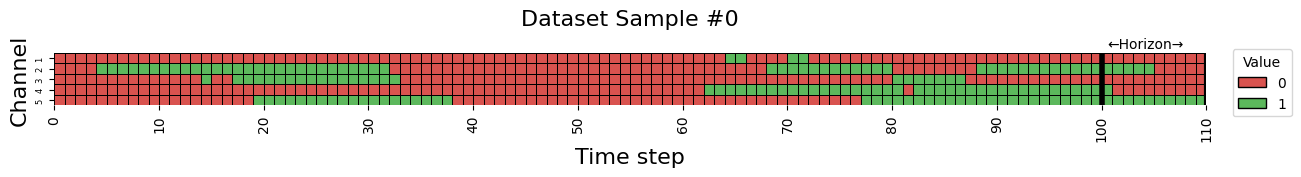

In [6]:
# Show heatmap sample from dataset
heatmap_dataset_sample_binary(X, y, sample_index=0)


## 6.&nbsp;LSTM model definition
Defines the LSTM model

In [7]:
class LSTM_model(nn.Module):
  def __init__(self, num_channels, horizon=10, hidden_size=256):
    super().__init__()
    self.horizon = horizon
    self.num_channels = num_channels
    self.lstm = nn.LSTM(input_size=num_channels, hidden_size=hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_channels * horizon)

  def forward(self, x):
    out, _ =self.lstm(x)
    last_out = out[:, -1, :]
    preds = self.fc(last_out)
    preds = preds.view(-1, self.horizon, self.num_channels)
    return torch.sigmoid(preds)

## 7.&nbsp;Training loop
Training loop for model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Parameters
num_channels = X.shape[2]  # 5 channels
horizon = y.shape[1]       # 10 time steps ahead
loss_values = []
#epochs = 100
#lr = 0.001 # learning rate

model = LSTM_model(num_channels=num_channels, horizon=horizon)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.BCELoss()

# Variable to track best loss
best_loss = float('inf')
best_model_state = None  # to store the best model

# Training loop
for epoch in range(1, config['num_epochs'] +1):
  model.train()
  epoch_loss = 0.0

  for X_batch, y_batch in dataloader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * X_batch.size(0)

  avg_loss = epoch_loss / len(dataset)
  loss_values.append(avg_loss)
  print(f"Epoch {epoch}/{config['num_epochs']} - Loss: {avg_loss:.4f}")

  # Save best model
  if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # save model weights
        #print(f"  --> New best loss, saving model.")

# load the best model
model.load_state_dict(best_model_state)
print(f"Training complete. Best loss: {best_loss:.4f}")

Epoch 1/100 - Loss: 0.6751
Epoch 2/100 - Loss: 0.6340
Epoch 3/100 - Loss: 0.5965
Epoch 4/100 - Loss: 0.5624
Epoch 5/100 - Loss: 0.5418
Epoch 6/100 - Loss: 0.5118
Epoch 7/100 - Loss: 0.4870
Epoch 8/100 - Loss: 0.4537
Epoch 9/100 - Loss: 0.4144
Epoch 10/100 - Loss: 0.3925
Epoch 11/100 - Loss: 0.3645
Epoch 12/100 - Loss: 0.3449
Epoch 13/100 - Loss: 0.4526
Epoch 14/100 - Loss: 0.5019
Epoch 15/100 - Loss: 0.4424
Epoch 16/100 - Loss: 0.4018
Epoch 17/100 - Loss: 0.3818
Epoch 18/100 - Loss: 0.3479
Epoch 19/100 - Loss: 0.3270
Epoch 20/100 - Loss: 0.3200
Epoch 21/100 - Loss: 0.3047
Epoch 22/100 - Loss: 0.3749
Epoch 23/100 - Loss: 0.3516
Epoch 24/100 - Loss: 0.3068
Epoch 25/100 - Loss: 0.2769
Epoch 26/100 - Loss: 0.2622
Epoch 27/100 - Loss: 0.2507
Epoch 28/100 - Loss: 0.2389
Epoch 29/100 - Loss: 0.2304
Epoch 30/100 - Loss: 0.2387
Epoch 31/100 - Loss: 0.4837
Epoch 32/100 - Loss: 0.4950
Epoch 33/100 - Loss: 0.4324
Epoch 34/100 - Loss: 0.3990
Epoch 35/100 - Loss: 0.3519
Epoch 36/100 - Loss: 0.3204
E

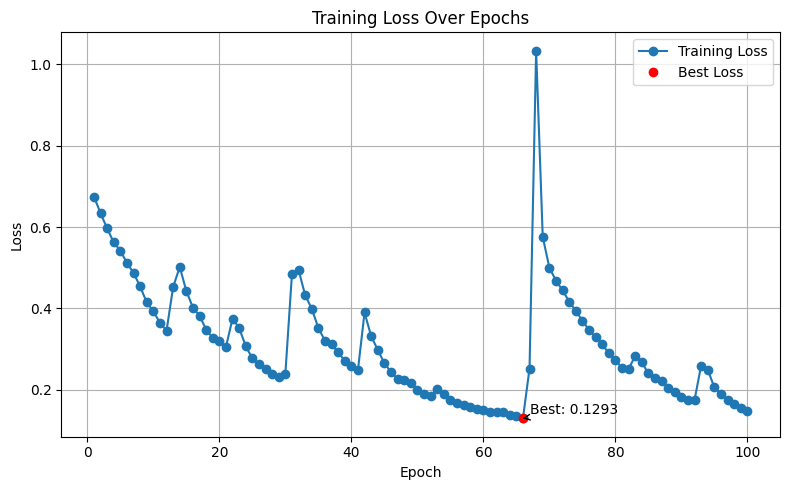

In [9]:
plot_loss(loss_values, config['num_epochs'])

## 8.&nbsp;Evaluate model on new dataset
Evaluates the trained model on a new dataset (generated using `simulate_multiple_channels`)

In [26]:
# TEST WITH FUNCTION MULTIPLE TESTS
def new_data():
    random_avg_on = random.randint(1, 100)
    random_avg_off = random.randint(1, 100)
    X_raw = simulate_multiple_channels(num_channels=5, signal_length=1000, avg_on_duration=random_avg_on, avg_off_duration=random_avg_off)
    X_raw_T = X_raw.T   # X_raw shape (5,1000) -> (1000,5)

    print(f"Generated test data with values:")
    print(f"avg_on_duration: {random_avg_on}")
    print(f"avg_off_duration: {random_avg_off}")

    # Creare sequences
    input_window = 100
    horizon = 10
    test_X, test_y = create_sequence(X_raw_T, input_window, horizon)

    test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)
    return test_X_tensor, test_y_tensor


def run_tests(num_tests):


    accuracy_values = []

    # load model with smallest loss
    model.load_state_dict(best_model_state)
    model.to(device)
    model.eval()
    print(f"Loaded best model with loss: {best_loss:.4f}")

    test_results = []

    for i in range(1, num_tests):
        with torch.no_grad():
            preds = model(test_X_tensor)  # shape: (num_samples, horizon, num_channels)

        preds_binary = (preds >= 0.5).int() # converts probabilities to either 1 or 0

        correct = (preds_binary == test_y_tensor.int()).sum().item()
        total = torch.numel(test_y_tensor)
        accuracy = correct / total
        print(f"Evaluation accuracy on new dataset: {accuracy*100:.2f}%")

        accuracy_values.append(accuracy * 100)

        test_results.append(accuracy_values)
    return print(test_results)

run_tests(num_tests = 10)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
Generated test data with values:
avg_on_duration: 27
avg_off_duration: 76
Loaded best model with loss: 0.1293
Evaluation accuracy on new dataset: 71.80%
Evaluation accuracy on new dataset: 71.80%
Evaluation accuracy on new dataset: 71.80%
Evaluation accuracy on new dataset: 71.80%
Evaluation accuracy on new dataset: 71.80%
Evaluation accuracy on new dataset: 71.80%
Evaluation accuracy on new dataset: 71.80%
Evaluation accuracy on new dataset: 71.80%
Evaluation accuracy on new dataset: 71.80%
[[71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846], [71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846, 71.79573512906846], [71.79

In [24]:
random_avg_on = random.randint(1, 100)
random_avg_off = random.randint(1, 100)
X_raw = simulate_multiple_channels(num_channels=5, signal_length=1000, avg_on_duration=random_avg_on, avg_off_duration=random_avg_off)
X_raw_T = X_raw.T   # X_raw shape (5,1000) -> (1000,5)

print(f"Generated test data with values:")
print(f"avg_on_duration: {random_avg_on}")
print(f"avg_off_duration: {random_avg_off}")

# Creare sequences
input_window = 100
horizon = 10
test_X, test_y = create_sequence(X_raw_T, input_window, horizon)

test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)

accuracy_values = []

# load model with smallest loss
model.load_state_dict(best_model_state)
model.to(device)
model.eval()
print(f"Loaded best model with loss: {best_loss:.4f}")

num_tests = 10
test_results = []

for i in range(1, num_tests):
    with torch.no_grad():
        preds = model(test_X_tensor)  # shape: (num_samples, horizon, num_channels)

    preds_binary = (preds >= 0.5).int() # converts probabilities to either 1 or 0

    correct = (preds_binary == test_y_tensor.int()).sum().item()
    total = torch.numel(test_y_tensor)
    accuracy = correct / total
    print(f"Evaluation accuracy on new dataset: {accuracy*100:.2f}%")

    accuracy_values.append(accuracy * 100)

    test_results.append(accuracy_values)

print(test_results)

# =================== preds full testing =================
# Initialize array for full length predictions
preds_np = preds_binary.cpu().numpy()  # convert to numpy
num_samples, horizon, num_channels = preds_np.shape
pred_full = np.zeros((num_channels, X_raw.shape[1]))

# slide horizon predictions over time
for i in range(num_samples):
    start_idx = i
    end_idx = i + horizon
    if end_idx > X_raw.shape[1]:
        end_idx = X_raw.shape[1]
    length = end_idx - start_idx
    pred_full[:, start_idx:end_idx] = preds_np[i, :length, :].T

# testing
#print(f"test_X_tensor: {test_X_tensor}")
#print(f"preds: {preds}")
#print(preds.shape)
#print(f"preds binary: {preds_binary}")
#print(f"test X tensor: {test_X_tensor}")
#print(f"correct: {correct}")
#print(f"total: {total}")

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
Generated test data with values:
avg_on_duration: 18
avg_off_duration: 40
Loaded best model with loss: 0.1293
Evaluation accuracy on new dataset: 65.70%
Evaluation accuracy on new dataset: 65.70%
Evaluation accuracy on new dataset: 65.70%
Evaluation accuracy on new dataset: 65.70%
Evaluation accuracy on new dataset: 65.70%
Evaluation accuracy on new dataset: 65.70%
Evaluation accuracy on new dataset: 65.70%
Evaluation accuracy on new dataset: 65.70%
Evaluation accuracy on new dataset: 65.70%
[[65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236], [65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236, 65.70145903479236], [65.70

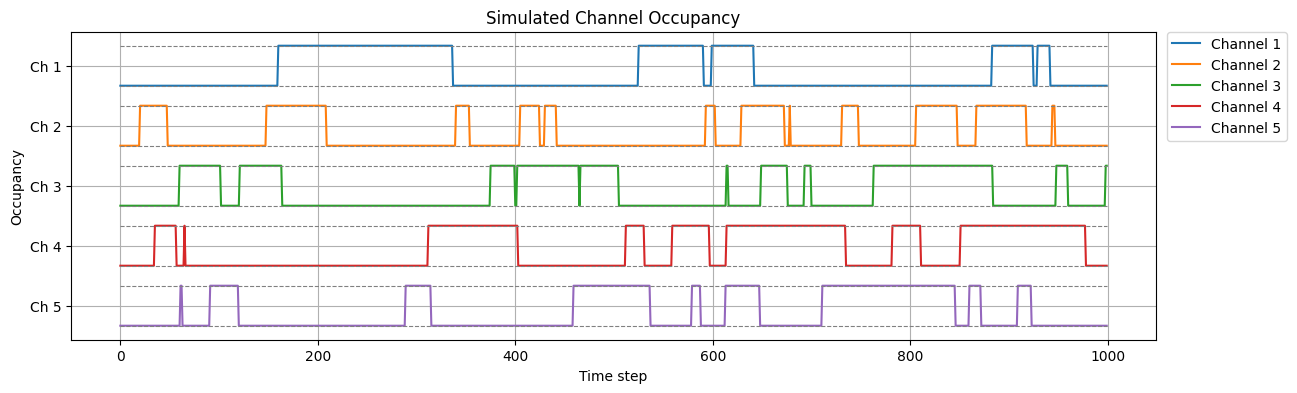

In [11]:
# show new dataset in plot
channel_data = X_raw
plot_channels(channel_data, num_channels)

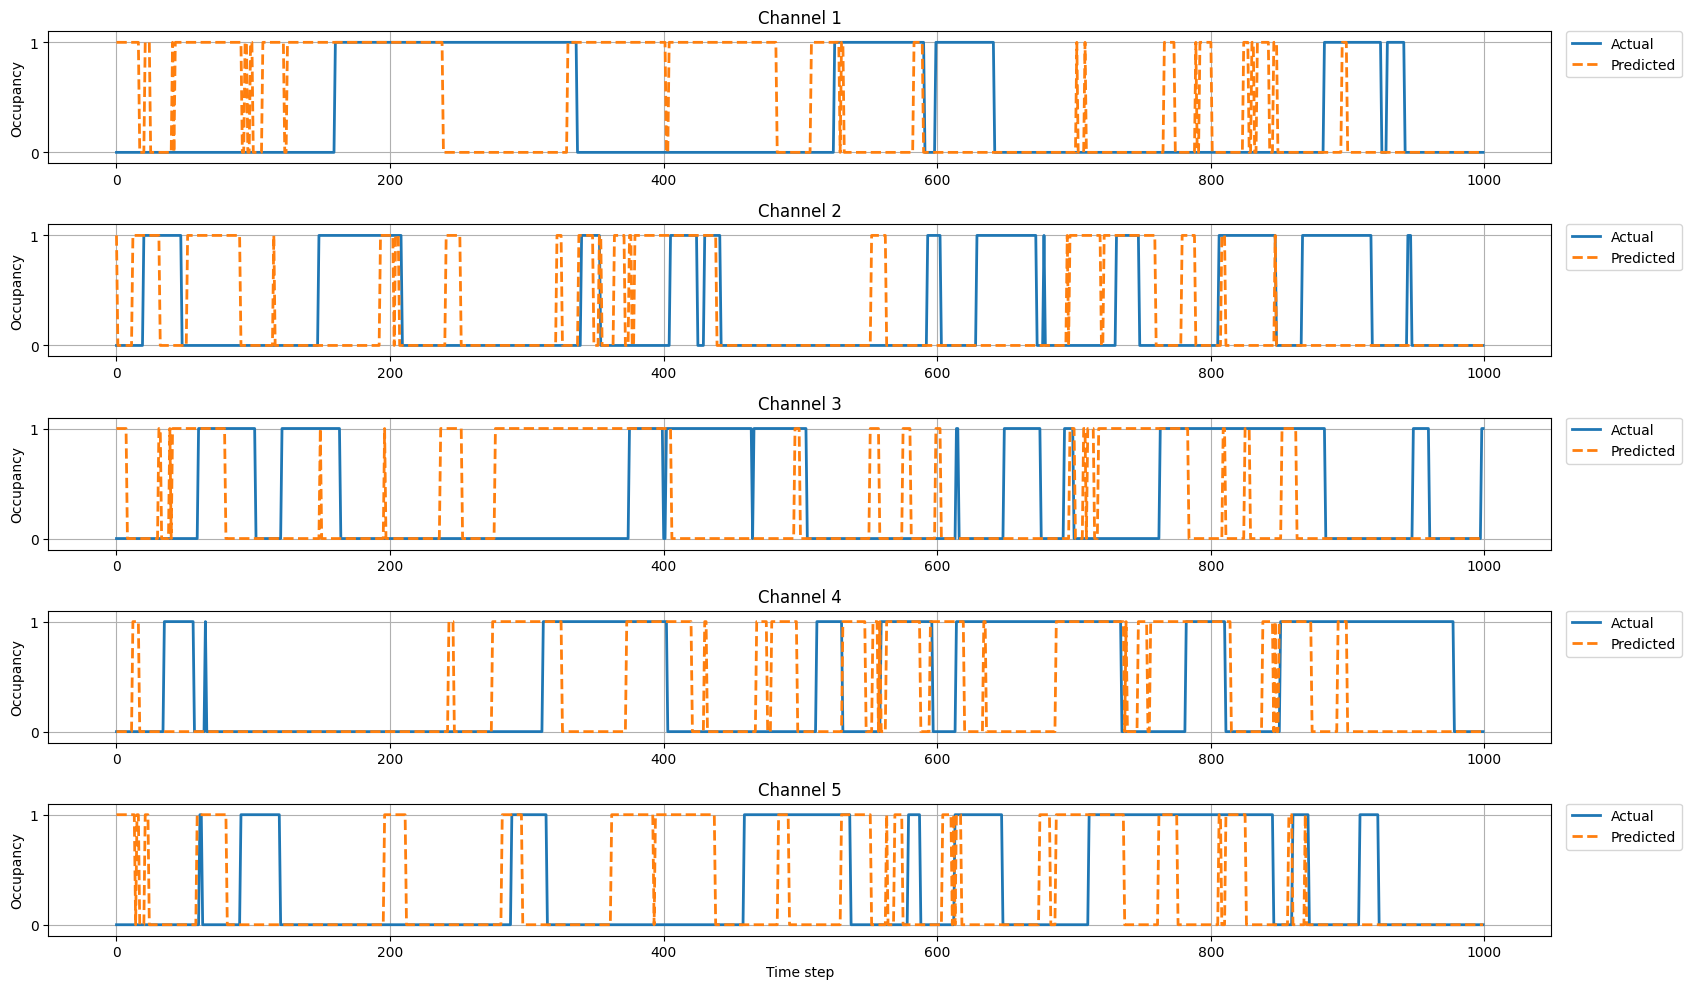

In [12]:
# compact comparison plot
plot_compact_comparison(X_raw, preds_binary)

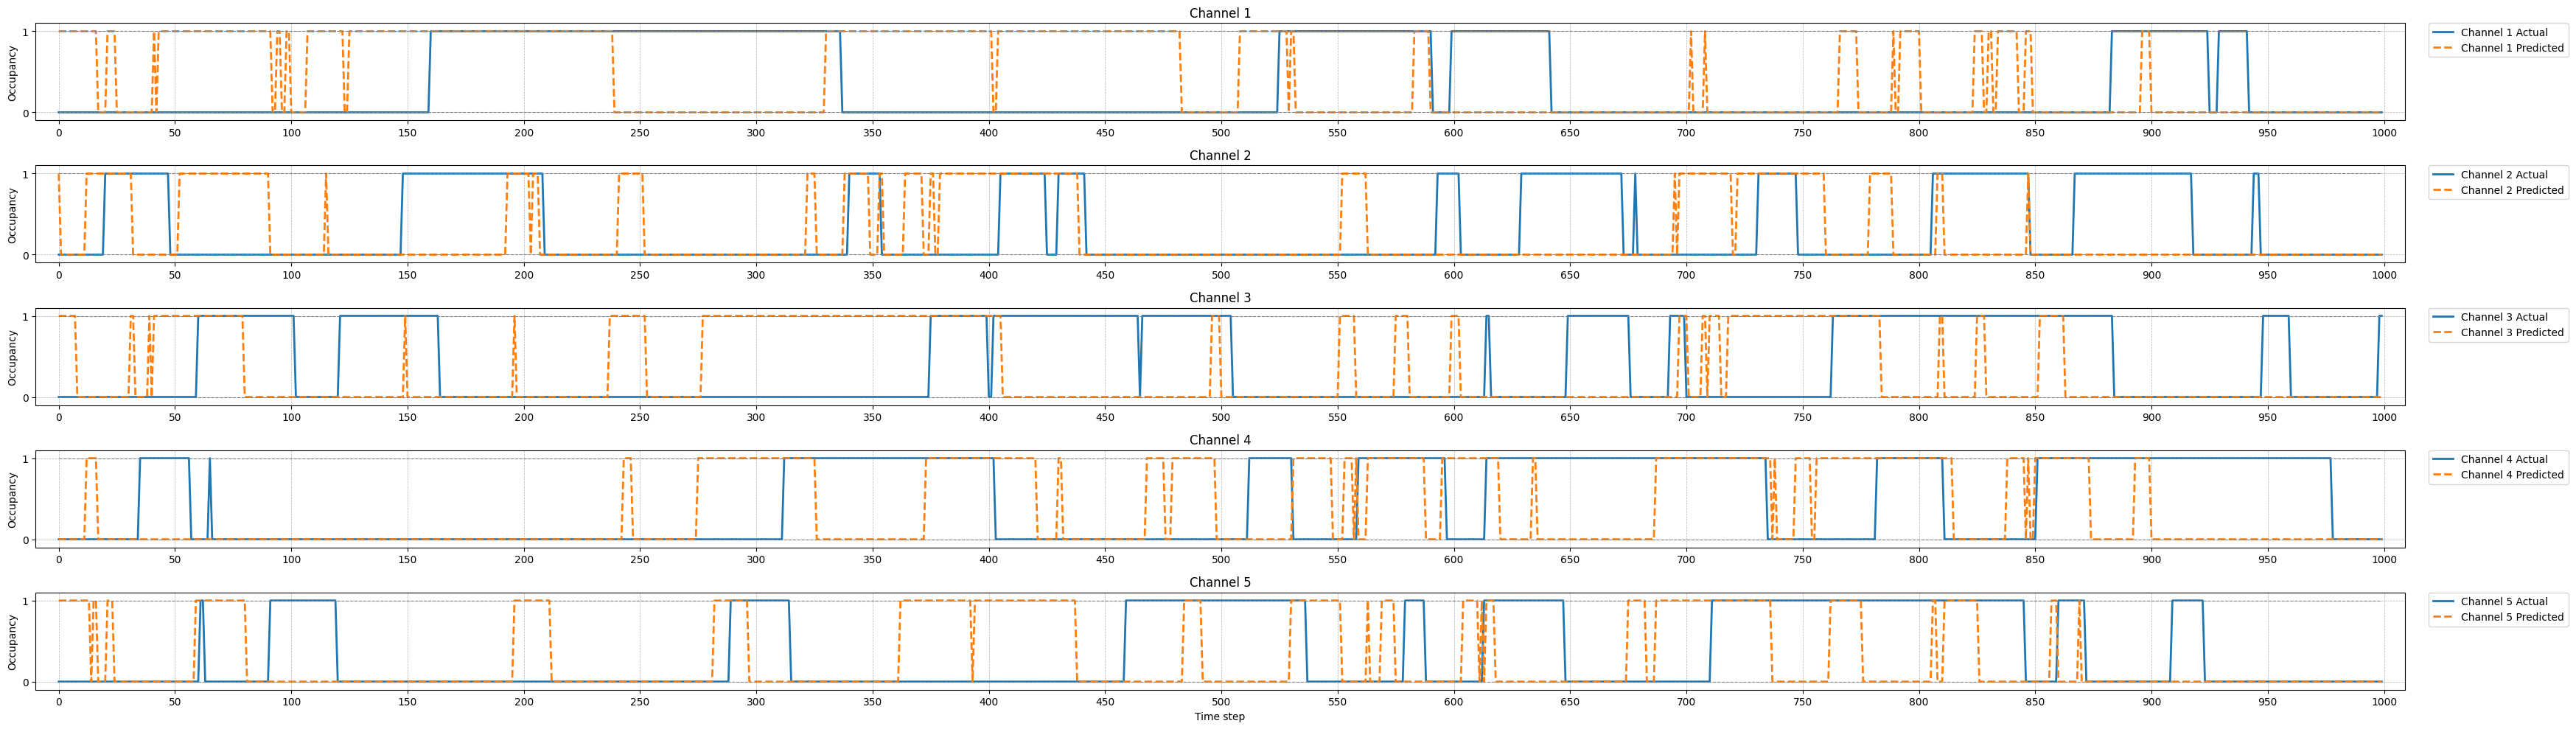

In [13]:
# full comparison plot
plot_full_comparison(X_raw, pred_full)

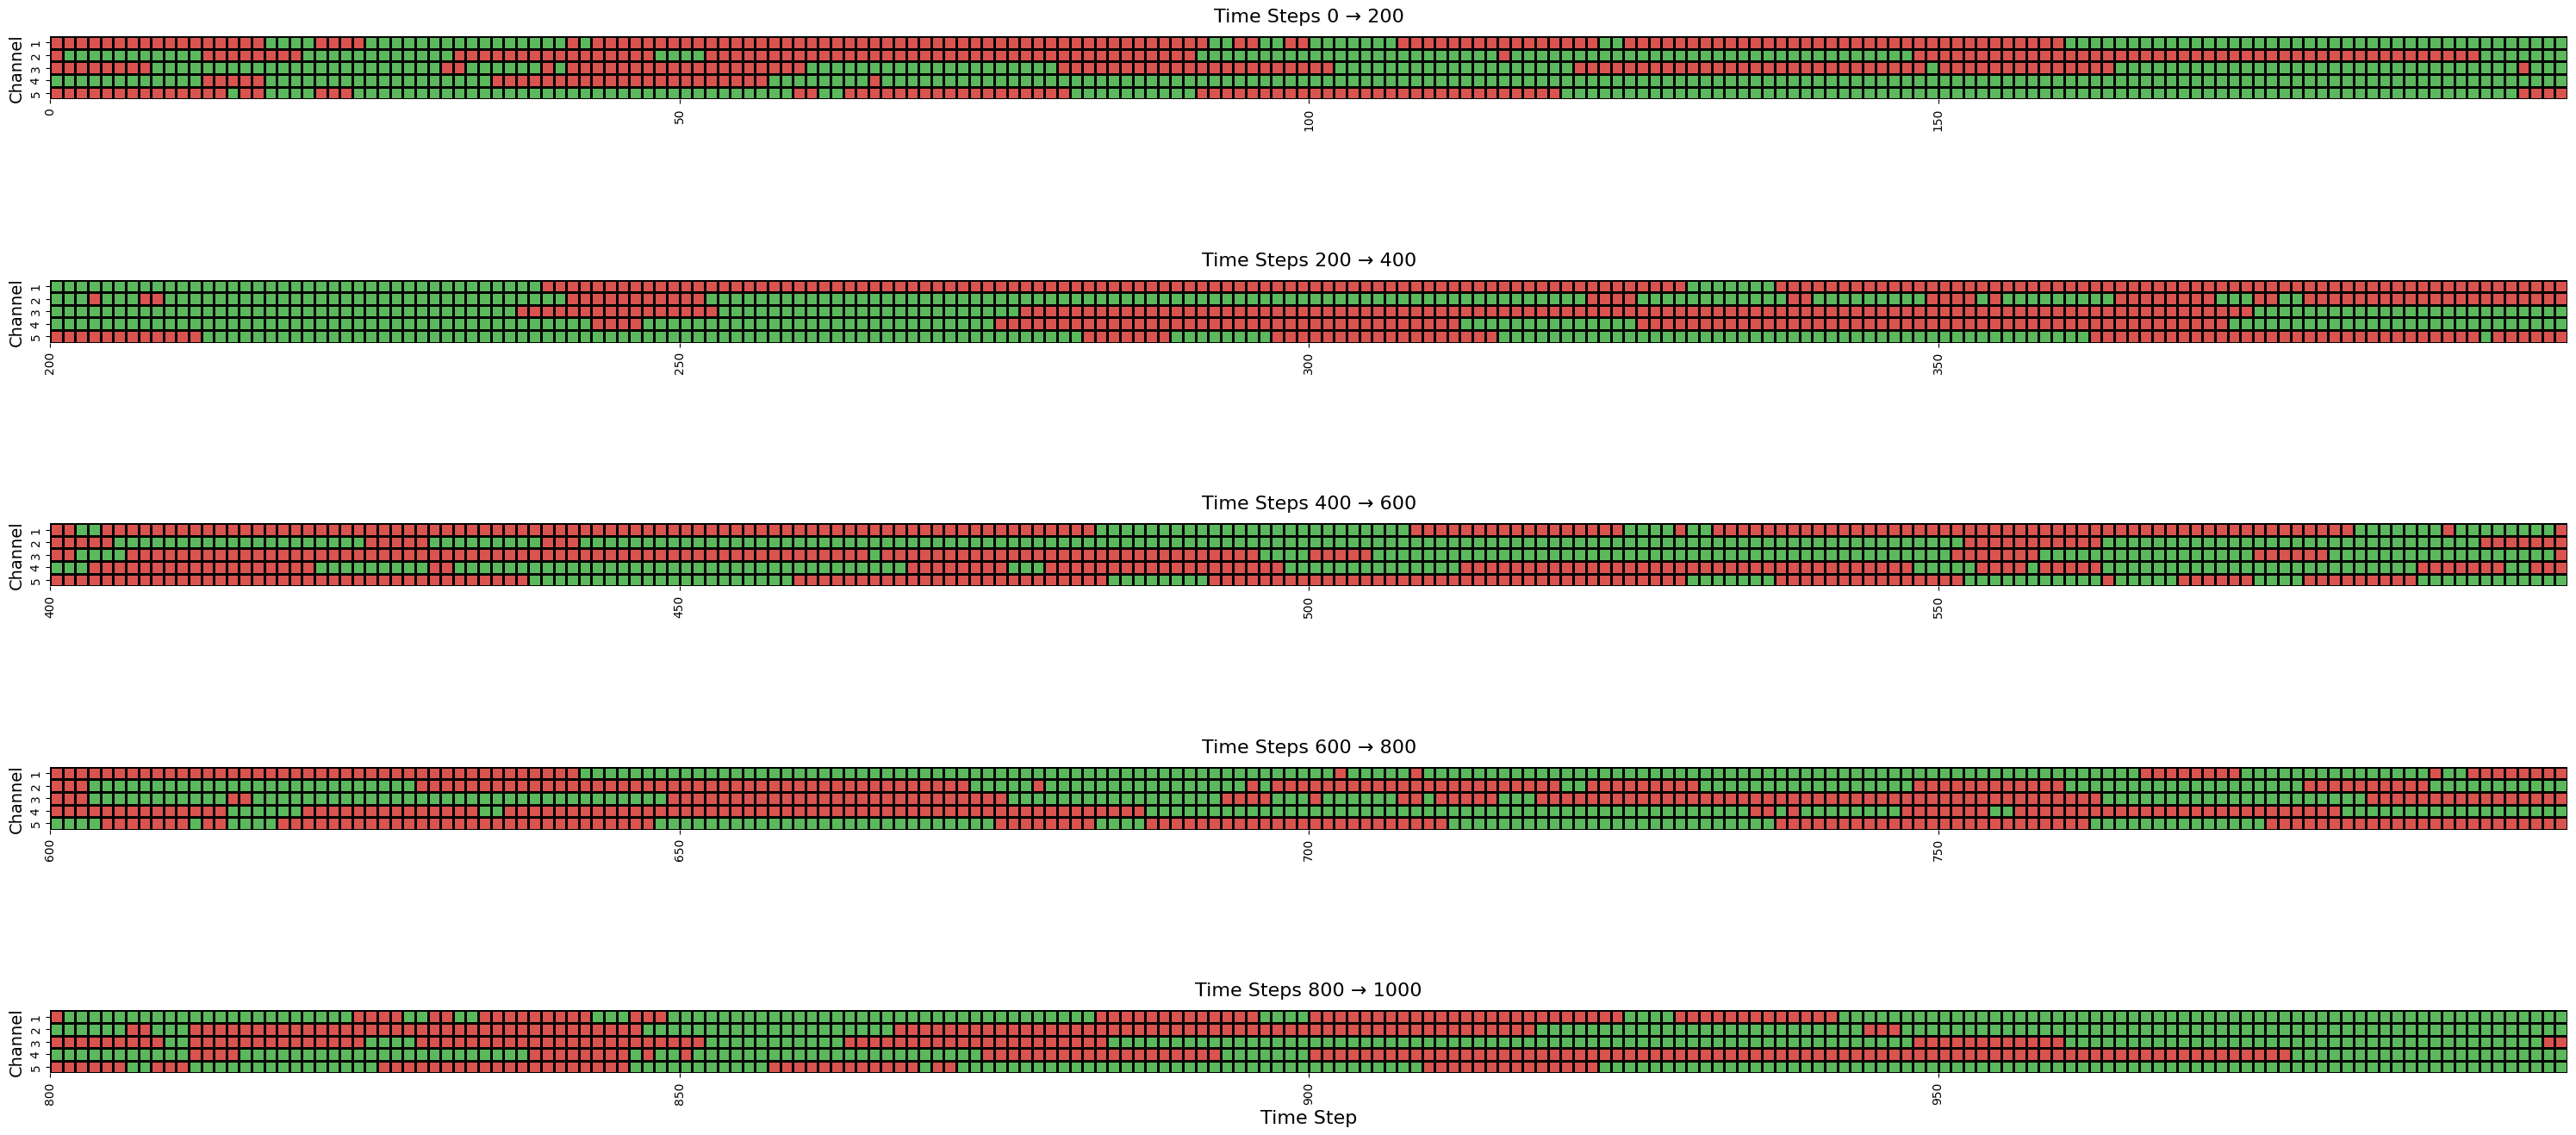

In [14]:
# heatmap subgraph
heatmap_subgraphed_correctness(X_raw, pred_full)

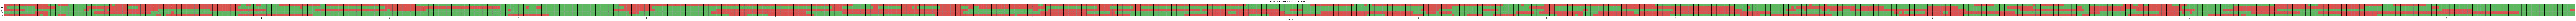

In [15]:
# heatmap full
heatmap_full_correctness(X_raw, pred_full)

## TESTING

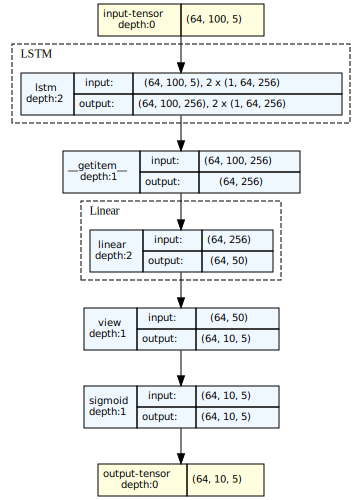

In [16]:
# torchviz
# Model and input setup
num_channels = 5
horizon = 10
hidden_size = 256
batch_size = 64
seq_length = 100

model = LSTM_model(num_channels=num_channels, horizon=config['horizon'], hidden_size=config['hidden_size'])

# Generate the clean model graph with output shapes
graph = draw_graph(
    model,
    input_size=(batch_size, seq_length, num_channels),  # Input shape: [64, 100, 5]
    device="cpu",
    expand_nested=True,
    depth=3,               # Show internal layers clearly
    save_graph=True,
    graph_name="lstm_training_flow",
    hide_module_functions=False
)

# Display the PNG inline in Colab or Jupyter
graph.visual_graph

In [17]:
# torchinfo
summary(model)

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              269,312
├─Linear: 1-2                            12,850
Total params: 282,162
Trainable params: 282,162
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              269,312
├─Linear: 1-2                            12,850
Total params: 282,162
Trainable params: 282,162
Non-trainable params: 0